## Generate Fig 3 
CMG A065 - 3.45 nm

In [1]:
%reset
import pandas as pd 
import os
import glob
import sys
import subprocess
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pylab import *
plt.style.use('ggplot')
import matplotlib.gridspec as gridspec
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Import all the data

In [2]:
folder_name = 'D:/PPMS Data/Analysis/CMG Tdep'
os.chdir(folder_name)
file_name = '001_MedTdep__375K-3K_A065_CMG.dat'
thick = 3.45

data =  np.genfromtxt(file_name,delimiter=',',usecols=(3,4,5,20,21,34),skip_header=32,names=None)
c_names = ['Temp1','Field','Pos','Resistance','AHE','Temp2']
df_data = pd.DataFrame(data[:].copy(), columns=c_names)
df_data['Thick'] = thick

Correct for VdP geometry factor, and calculate resistivity using shunt current model

In [3]:
df_data['Resistance_vdp']= df_data['Resistance']*4.53 # This is the vdP factor
df_data['Resistivity'] = df_data['Resistance_vdp']*(df_data['Thick'])*1E-7/(1-(df_data['Resistance_vdp']*2.5E-7/60E-6))
# Although, bear in mind, we are not including any temperature dependence of the Pd layer!
# Also calculate a total/effective resistivity:
df_data['Resistivity_eff']=df_data['Resistance_vdp']*(df_data['Thick']*(1E-7) + 2.5E-7)

### Plot the resistivity vs Temperature

Using a shunt-model without T-dependence exadurates the T-dep of the magnetic layer.

## Split the data into the different temperatures

In [4]:
df1 = df_data.copy()
df1['Temp2_diff']=df1['Temp2'].diff()
df_filt = df1[df1['Temp2_diff'].abs() > 2]

ends = df_filt.index.tolist()
start_0 = 0
ends.insert(0,start_0)
ends.append(len(df1))
dataframes = {} # Create a dict to store all the dataframes

for i in range(len(df_filt)+1):
    start = ends[i]
    end = ends[i+1]-1
    dataframes[i] = df1.ix[start:end,:]

corr_data = {} # Create a dict to store the corrected dataframes

for i in range(len(df_filt)+1):
    df = dataframes[i].copy()

    dfc = df.copy()
    h_max = dfc['AHE'].max()
    h_min = dfc['AHE'].min()
    shift = h_min + (h_max-h_min)/2
    dfc['AHE'] = dfc['AHE']*(-1) + shift

    corr_data[i]=dfc

In [5]:
df_375 = corr_data[0]
df_350 = corr_data[16]
df_325 = corr_data[1]
df_300 = corr_data[15]


### Plot all the data, with AHE offset removed

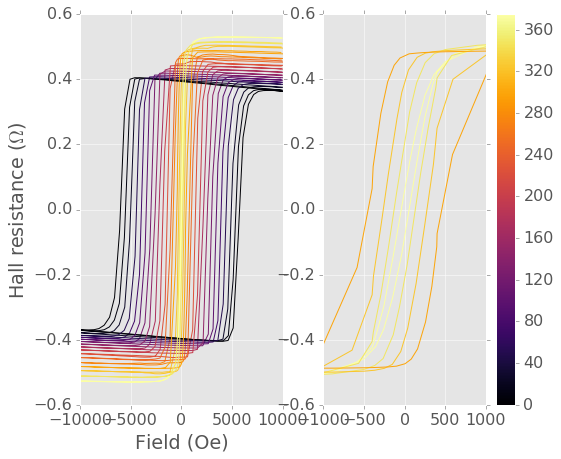

In [6]:
T=[]
fig1 = plt.figure(figsize=(8,7))


ax1 = fig1.add_subplot(121)
for name, df in corr_data.items():
    temperature = df['Temp2'].iloc[1]/376
    T.append(temperature)
    cmap = plt.get_cmap('inferno')
    colors = cmap(temperature)
    ax1.plot(df['Field'],df['AHE'],c=colors)
ax1.set_xlim([-10000,10000])
ax1.set_xlabel('Field (Oe)')
ax1.set_ylabel('Hall resistance ($\Omega$)')


ax2 = fig1.add_subplot(122)
ax2.plot(df_375['Field'],df_375['AHE'],c=cmap(375/375))
ax2.plot(df_350['Field'],df_350['AHE'],c=cmap(350/375))
ax2.plot(df_325['Field'],df_325['AHE'],c=cmap(325/375))
ax2.plot(df_300['Field'],df_300['AHE'],c=cmap(300/375))
ax2.set_xlim([-1000,1000])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=375))
sm.set_array(T)
plt.colorbar(sm)

### Now extract all of the parameters

In [7]:
data_dict = {}
Thickness = []
Resistivity = []
R_eff = []
Rem = []
AHE = []
AHE_fit = []
Temperature = []
H_coercive = []
Slope = []


for temp, df1 in corr_data.items():

    thick = df1['Thick'].iloc[0]
    temperature = df1['Temp2'].iloc[1]
    resistance = df1['Resistance'].mean()
    resistivity = df1['Resistivity'].mean()
    r_eff = df1['Resistivity_eff'].mean()
    #================================================
    # Get the normal Hall slope
    #================================================        
    df_aa = df1.head(50)
    df_a = df_aa[(df_aa['Field'] > 5000)]
    x1 = df_a['Field'].values
    y1 = df_a['AHE'].values
    fit1 = np.polyfit(x1,y1,1)
    polynomial1 = np.poly1d(fit1)
    y1s = polynomial1(x1)
    df_bb = df1.tail(50)
    df_b = df_bb[(df_bb['Field'] < -5000)]
    x2 = df_b['Field'].values
    y2 = df_b['AHE'].values
    fit2 = np.polyfit(x2,y2,1)
    polynomial2 = np.poly1d(fit2)
    y2s = polynomial2(x2)
    slope = (fit1[0]+fit2[0])/2
           
    #================================================
    # Get the AHE        
    #================================================
    x=0
    df2 = df1.iloc[(df1.Field-x).abs().argsort()[:4]]
    ahe = df2['AHE'].abs().mean()
    #        
    sign = df1.iloc[-2]['AHE']
    sign = sign/abs(sign)
    ahe=ahe*sign
    #================================================
    # Get the AHE from the fits       
    #================================================
    ahe_fit = (abs(fit2[1])+abs(fit2[1]))/2
    #================================================
    # Get the Hc     
    #================================================
    df1['AHE_diff']=df1['AHE'].diff().abs()
    df_hc1 = df1.sort_values('AHE_diff',ascending=False).head(2)
    Hc1 = df_hc1.Field.abs().mean()

    x=0
    df_hc2 = df1.iloc[(df1.AHE-x).abs().argsort()[:4]]
    Hc2 = df_hc2['Field'].abs().mean()
    
    Hc = (Hc1+Hc2)/2
    #================================================
    # Get the Remnance     
    #================================================
    x=0
    df_rem = df1.iloc[(df1.Field-x).abs().argsort()[:2]]
    rem = df_rem['AHE'].abs().mean()
    remnance = rem/ahe_fit
    #================================================
    # Compile all the results       
    #================================================
    Thickness.append(thick)
    Resistivity.append(resistivity)
    Temperature.append(temperature)
    AHE.append(ahe)
    AHE_fit.append(ahe_fit)
    H_coercive.append(Hc)
    Slope.append(slope)
    R_eff.append(r_eff)
    Rem.append(remnance)

data_all = pd.DataFrame({'Temperature': Temperature,'R_eff':R_eff,'Rem':Rem, 'Thickness':Thickness, 'Resistivity':Resistivity, 'AHE': AHE, 'AHE_fit': AHE_fit, 'H_c':H_coercive, 'Slope':Slope})

## Load the data for A074 - 4.1nm

In [8]:
#data_A074 = pd.read_csv("A074_Tdep.csv",index_col=0)
data_A074 = pd.read_csv("data_CMG_A074_corr.csv",index_col=0)


## Look at the data

First, just the raw temperature dependence

### AHE and H_c

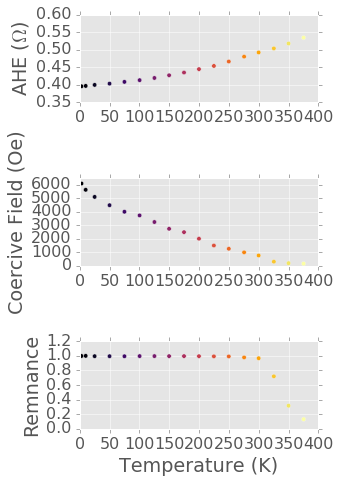

In [9]:
fig1 = plt.figure(figsize=(5,7))

ax1 = fig1.add_subplot(311)
ax1.scatter(data_all.Temperature, data_all.AHE_fit, c=data_all.Temperature, cmap='inferno')
ax1.set_ylabel('AHE ($\Omega$)')
ax1.set_xlim(0,400)

ax2 = fig1.add_subplot(312)
ax2.scatter(data_all.Temperature, data_all.H_c, c=data_all.Temperature, cmap='inferno')
ax2.set_ylabel('Coercive Field (Oe)')
#ax2.set_xlabel('Temperature (K)')
ax2.set_xlim(0,400)
ax2.set_ylim(0,6500)

ax3 = fig1.add_subplot(313)
ax3.scatter(data_all.Temperature, data_all.Rem, c=data_all.Temperature, cmap='inferno')
ax3.set_ylabel('Remnance')
ax3.set_xlabel('Temperature (K)')
ax3.set_xlim(0,400)
#ax3.set_ylim(0,6500)

fig1.tight_layout()

# Generate the final figure

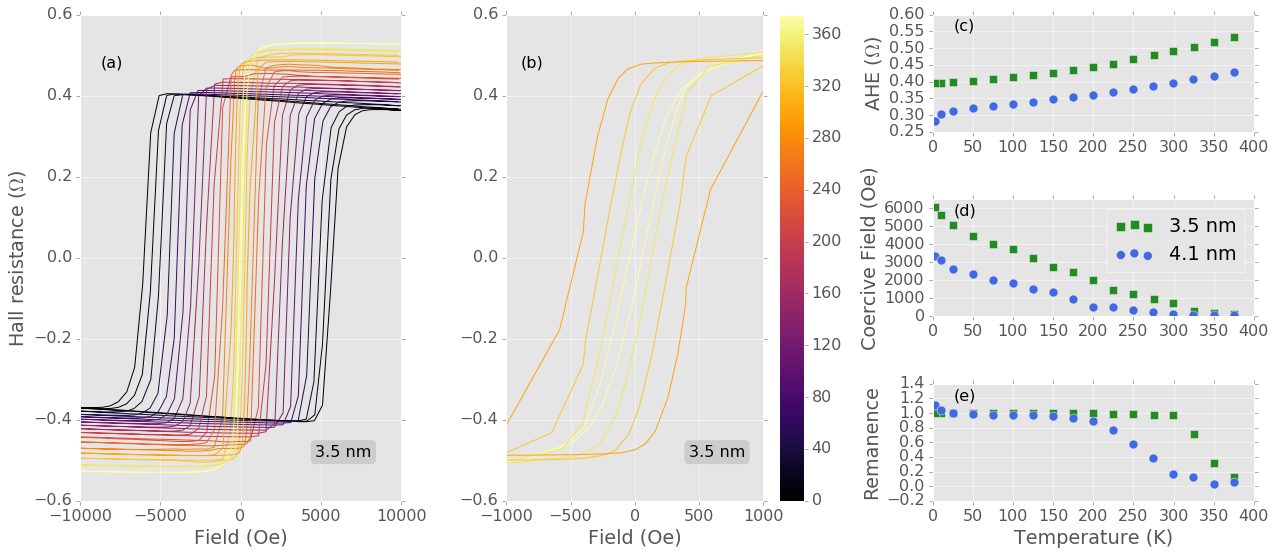

In [12]:
folder_name = 'D:/Papers/Paper - PMA CMG/Fig3'
os.chdir(folder_name)

fig1 = plt.figure(figsize=(18,8))

gs1 = gridspec.GridSpec(3, 3)
#gs1.update(left=0.01, right=0.3, wspace=0.8)
ax1 = plt.subplot(gs1[:, 0])
ax2 = plt.subplot(gs1[:, 1])
ax3 = plt.subplot(gs1[0,2])
ax4 = plt.subplot(gs1[1, 2])
ax5 = plt.subplot(gs1[2, 2])



"""
Fill in left hand column
"""
for name, df in corr_data.items():
    temperature = df['Temp2'].iloc[1]/376
    T.append(temperature)
    cmap = plt.get_cmap('inferno')
    colors = cmap(temperature)
    ax1.plot(df['Field'],df['AHE'],c=colors)
ax1.set_xlim([-10000,10000])
ax1.set_xlabel('Field (Oe)')
ax1.set_ylabel('Hall resistance ($\Omega$)')

ax1.annotate('(a)', xy=(.1, 0.9), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center')
ax1.annotate('3.5 nm', xy=(.82, 0.1), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
            bbox=dict(boxstyle="round", fc="0.8"))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=375))
sm.set_array(T)
plt.colorbar(sm, ax=ax2)


"""
Fill in centre column
"""
ax2.plot(df_375['Field'],df_375['AHE'],c=cmap(375/375))
ax2.plot(df_350['Field'],df_350['AHE'],c=cmap(350/375))
ax2.plot(df_325['Field'],df_325['AHE'],c=cmap(325/375))
ax2.plot(df_300['Field'],df_300['AHE'],c=cmap(300/375))
ax2.set_xlim([-1000,1000])
ax2.set_xlabel('Field (Oe)')
ax2.annotate('(b)', xy=(.1, 0.9), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center')
ax2.annotate('3.5 nm', xy=(.82, 0.1), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
            bbox=dict(boxstyle="round", fc="0.8"))

"""
Fill in right hand column
"""
ax3.scatter(data_all.Temperature, data_all.AHE_fit, c='forestgreen', marker = 's',s=80)
ax3.scatter(data_A074.Temperature, data_A074.AHE_fit, c='royalblue',s=80)
ax3.set_ylabel('AHE ($\Omega$)')
ax3.set_xlim(0,400)
ax3.annotate('(c)', xy=(.1, 0.9), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center')

ax4.scatter(data_all.Temperature, data_all.H_c, c='forestgreen', s=80, marker = 's',label = '3.5 nm')
ax4.scatter(data_A074.Temperature, data_A074.H_c, c='royalblue',s=80, label = '4.1 nm')
ax4.set_ylabel('Coercive Field (Oe)')
#ax2.set_xlabel('Temperature (K)')
ax4.set_xlim(0,400)
ax4.set_ylim(0,6500)
ax4.annotate('(d)', xy=(.1, 0.9), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center')
ax4.legend()

ax5.scatter(data_all.Temperature, data_all.Rem, c='forestgreen', marker = 's',s=80)
ax5.scatter(data_A074.Temperature, data_A074.Rem, c='royalblue',s=80)
ax5.set_ylabel('Remanence')
ax5.set_xlabel('Temperature (K)')
ax5.set_xlim(0,400)
ax5.annotate('(e)', xy=(.1, 0.9), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center')
fig1.tight_layout()
#savefig('Fig3.jpg',dpi=600,bbox_inches='tight')
#savefig('Fig3.pdf',dpi=900,bbox_inches='tight')